# The Income Fluctuation Problem II: Stochastic Returns on Assets

## Contents

- [The Income Fluctuation Problem II: Stochastic Returns on Assets](#The-Income-Fluctuation-Problem-II:-Stochastic-Returns-on-Assets)  
  - [Overview](#Overview)  
  - [The Savings Problem](#The-Savings-Problem)  
  - [Solution Algorithm](#Solution-Algorithm)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!conda install -y quantecon
!pip install interpolation

Solving environment: done

# All requested packages already installed.



## Overview

In this lecture, we continue our study of the [income fluctuation problem](https://python.quantecon.org/ifp.html).

While the interest rate was previously taken to be fixed, we now allow
returns on assets to be state-dependent.

This matches the fact that most households with a positive level of assets
face some capital income risk.

It has been argued that modeling capital income risk is essential for
understanding the joint distribution of income and wealth (see, e.g.,
[[BBZ15]](https://python.quantecon.org/zreferences.html#benhabib2015) or [[ST19b]](https://python.quantecon.org/zreferences.html#stachurski2019impossibility)).

Theoretical properties of the household savings model presented here are
analyzed in detail in [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income).

In terms of computation, we use a combination of time iteration and the
endogenous grid method to solve the model quickly and accurately.

We require the following imports:

In [2]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain

## The Savings Problem

In this section we review the household problem and optimality results.

### Set Up

A household chooses a consumption-asset path $ \{(c_t, a_t)\} $ to
maximize


<a id='equation-trans-at'></a>
$$
\mathbb E \left\{ \sum_{t=0}^\infty \beta^t u(c_t) \right\} \tag{1}
$$

subject to


<a id='equation-trans-at2'></a>
$$
a_{t+1} = R_{t+1} (a_t - c_t) + Y_{t+1}
\; \text{ and } \;
0 \leq c_t \leq a_t, \tag{2}
$$

with initial condition $ (a_0, Z_0)=(a,z) $ treated as given.

Note that $ \{R_t\}_{t \geq 1} $, the gross rate of return on wealth, is allowed to be stochastic.

The sequence $ \{Y_t \}_{t \geq 1} $ is non-financial income.

The stochastic components of the problem obey


<a id='equation-eq-ry-func'></a>
$$
R_t = R(Z_t, \zeta_t)
  \quad \text{and} \quad
Y_t = Y(Z_t, \eta_t), \tag{3}
$$

where

- the maps $ R $ and $ Y $ are time-invariant nonnegative functions,  
- the innovation processes $ \{\zeta_t\} $ and
  $ \{\eta_t\} $ are IID and independent of each other, and  
- $ \{Z_t\}_{t \geq 0} $ is an irreducible time-homogeneous Markov chain on a finite set $ \mathsf Z $  


Let $ P $ represent the Markov matrix for the chain $ \{Z_t\}_{t \geq 0} $.

Our assumptions on preferences are the same as our [previous lecture](https://python.quantecon.org/ifp.html) on the income fluctuation problem.

As before, $ \mathbb E_z \hat X $ means expectation of next period value
$ \hat X $ given current value $ Z = z $.

### Assumptions

We need restrictions to ensure that the objective [(35.1)](#equation-trans-at) is finite and
the solution methods described below converge.

We also need to ensure that the present discounted value of wealth
does not grow too quickly.

When $ \{R_t\} $ was constant we required that $ \beta R < 1 $.

Now it is stochastic, we require that


<a id='equation-fpbc2'></a>
$$
\beta G_R < 1,
\quad \text{where} \quad
G_R := \lim_{n \to \infty}
\left(\mathbb E \prod_{t=1}^n R_t \right)^{1/n} \tag{4}
$$

Notice that, when $ \{R_t\} $ takes some constant value $ R $, this
reduces to the previous restriction $ \beta R < 1 $

The value $ G_R $ can be thought of as the long run (geometric) average
gross rate of return.

More intuition behind [(35.4)](#equation-fpbc2) is provided in [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income).

Discussion on how to check it is given below.

Finally, we impose some routine technical restrictions on non-financial income. (**nissue:math processing error**)

$$
\mathbb E \, Y_t < \infty \text{ and } \mathbb E \, u'(Y_t) < \infty
\label{a:y0}
$$

One relatively simple setting where all these restrictions are satisfied is
the IID and CRRA environment of [[BBZ15]](https://python.quantecon.org/zreferences.html#benhabib2015).

### Optimality

Let the class of candidate consumption policies $ \mathscr C $ be defined
[as before](https://python.quantecon.org/ifp.html).

In [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income) it is shown that, under the stated assumptions,

- any $ \sigma \in \mathscr C $ satisfying the Euler equation is an
  optimal policy and  
- exactly one such policy exists in $ \mathscr C $.  


In the present setting, the Euler equation takes the form


<a id='equation-ifpa-euler'></a>
$$
(u' \circ \sigma) (a, z) =
\max \left\{
           \beta \, \mathbb E_z \,\hat{R} \,
             (u' \circ \sigma)[\hat{R}(a - \sigma(a, z)) + \hat{Y}, \, \hat{Z}],
          \, u'(a)
       \right\} \tag{5}
$$

(Intuition and derivation are similar to our [earlier lecture](https://python.quantecon.org/ifp.html) on
the income fluctuation problem.)

We again solve the Euler equation using time iteration, iterating with a
Coleman–Reffett operator $ K $ defined to match the Euler equation
[(35.5)](#equation-ifpa-euler).

## Solution Algorithm


<a id='index-1'></a>

### A Time Iteration Operator

Our definition of the candidate class $ \sigma \in \mathscr C $ of consumption
policies is the same as in our [earlier lecture](https://python.quantecon.org/ifp.html) on the income
fluctuation problem.

For fixed $ \sigma \in \mathscr C $ and $ (a,z) \in \mathbf S $, the value
$ K\sigma(a,z) $ of the function $ K\sigma $ at $ (a,z) $ is defined as the
$ \xi \in (0,a] $ that solves


<a id='equation-k-opr'></a>
$$
u'(\xi) =
\max \left\{
          \beta \, \mathbb E_z \, \hat{R} \,
             (u' \circ \sigma)[\hat{R}(a - \xi) + \hat{Y}, \, \hat{Z}],
          \, u'(a)
       \right\} \tag{6}
$$

The idea behind $ K $ is that, as can be seen from the definitions,
$ \sigma \in \mathscr C $ satisfies the Euler equation
if and only if $ K\sigma(a, z) = \sigma(a, z) $ for all $ (a, z) \in
\mathbf S $.

This means that fixed points of $ K $ in $ \mathscr C $ and optimal
consumption policies exactly coincide (see [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income) for more details).

### Convergence Properties

As before, we pair $ \mathscr C $ with the distance

$$
\rho(c,d)
:= \sup_{(a,z) \in \mathbf S}
          \left|
              \left(u' \circ c \right)(a,z) -
              \left(u' \circ d \right)(a,z)
          \right|,
$$

It can be shown that

1. $ (\mathscr C, \rho) $ is a complete metric space,  
1. there exists an integer $ n $ such that $ K^n $ is a contraction
  mapping on $ (\mathscr C, \rho) $, and  
1. The unique fixed point of $ K $ in $ \mathscr C $ is
  the unique optimal policy in $ \mathscr C $.  


We now have a clear path to successfully approximating the optimal policy:
choose some $ \sigma \in \mathscr C $ and then iterate with $ K $ until
convergence (as measured by the distance $ \rho $)(**Issue:.**)

### Using an Endogenous Grid

In the study of that model we found that it was possible to further
accelerate time iteration via the [endogenous grid method](https://python.quantecon.org/egm_policy_iter.html).

We will use the same method here.

The methodology is the same as it was for the optimal growth model, with the
minor exception that we need to remember that consumption is not always
interior.

In particular, optimal consumption can be equal to assets when the level of
assets is low.

#### Finding Optimal Consumption

The endogenous grid method (EGM) calls for us to take a grid of *savings*
values $ s_i $, where each such $ s $ is interpreted as $ s = a -
c $.

For the lowest grid point we take $ s_0 = 0 $.

For the corresponding $ a_0, c_0 $ pair we have $ a_0 = c_0 $.

This happens close to the origin, where assets are low and the household
consumes all that it can.

Although there are many solutions, the one we take is $ a_0 = c_0 = 0 $,
which pins down the policy at the origin, aiding interpolation.

For $ s > 0 $, we have, by definition, $ c < a $, and hence
consumption is interior.

Hence the max component of [(35.5)](#equation-ifpa-euler) drops out, and we solve for


<a id='equation-eqsifc2'></a>
$$
c_i =
(u')^{-1}
\left\{
    \beta \, \mathbb E_z
    \hat R
    (u' \circ \sigma) \, [\hat R s_i + \hat Y, \, \hat Z]
\right\} \tag{7}
$$

at each $ s_i $.

#### Iterating

Once we have the pairs $ \{s_i, c_i\} $, the endogenous asset grid is
obtained by $ a_i = c_i + s_i $.

Also, we held $ z \in \mathsf Z $ in the discussion above so we can pair
it with $ a_i $.

An approximation of the policy $ (a, z) \mapsto \sigma(a, z) $ can be
obtained by interpolating $ \{a_i, c_i\} $ at each $ z $.

In what follows, we use linear interpolation.

### Testing the Assumptions

Convergence of time iteration is dependent on the condition $ \beta G_R < 1 $ being satisfied.

One can check this using the fact that $ G_R $ is equal to the spectral
radius of the matrix $ L $ defined by

$$
L(z, \hat z) := P(z, \hat z) \int R(\hat z, x) \phi(x) dx
$$

This indentity (**Issue: identity**) is proved in [[MST20]](https://python.quantecon.org/zreferences.html#ma2020income), where $ \phi $ is the
density of the innovation $ \zeta_t $ to returns on assets.

(Remember that $ \mathsf Z $ is a finite set, so this expression defines a matrix.)

Checking the condition is even easier when $ \{R_t\} $ is IID.

In that case, it is clear from the definition of $ G_R $ that $ G_R $
is just $ \mathbb E R_t $.

We test the condition $ \beta \mathbb E R_t < 1 $ in the code below.

## Implementation

We will assume that $ R_t = \exp(a_r \zeta_t + b_r) $ where $ a_r, b_r $
are constants and $ \{ \zeta_t\} $ is IID standard normal.

We allow labor income to be correlated, with

$$
Y_t = \exp(a_y \eta_t + Z_t b_y)
$$

where $ \{ \eta_t\} $ is also IID standard normal
and $ \{ Z_t\} $ is a Markov chain taking values in $ \{0, 1\} $.

In [3]:
ifp_data = [
    ('γ', float64),              # utility parameter
    ('β', float64),              # discount factor
    ('P', float64[:, :]),        # transition probs for z_t
    ('a_r', float64),            # scale parameter for R_t
    ('b_r', float64),            # additive parameter for R_t
    ('a_y', float64),            # scale parameter for Y_t
    ('b_y', float64),            # additive parameter for Y_t
    ('s_grid', float64[:]),      # Grid over savings
    ('η_draws', float64[:]),     # Draws of innovation η for MC
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC
]

In [4]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation
    problem.
    """

    def __init__(self,
                 γ=1.5,
                 β=0.96,
                 P=np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 a_r=0.1,
                 b_r=0.0,
                 a_y=0.2,
                 b_y=0.5,
                 shock_draw_size=50,
                 grid_max=10,
                 grid_size=100,
                 seed=1234):

        np.random.seed(seed)  # arbitrary seed

        self.P, self.γ, self.β = P, γ, β
        self.a_r, self.b_r, self.a_y, self.b_y = a_r, b_r, a_y, b_y
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.s_grid = np.linspace(0, grid_max, grid_size)

        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        ER = np.exp(b_r + a_r**2 / 2)
        assert β * ER < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c):
        return c**(-self.γ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.γ)

    def R(self, z, ζ):
        return np.exp(self.a_r * ζ + self.b_r)

    def Y(self, z, η):
        return np.exp(self.a_y * η + (z * self.b_y))

Here’s the Coleman-Reffett operator based on EGM:

In [5]:
@njit
def K(a_in, σ_in, ifp):
    """
    The Coleman--Reffett operator for the income fluctuation problem,
    using the endogenous grid method.

        * ifp is an instance of IFP
        * a_in[i, z] is an asset grid
        * σ_in[i, z] is consumption at a_in[i, z]
    """

    # Simplify names
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    R, Y, P, β = ifp.R, ifp.Y, ifp.P, ifp.β
    s_grid, η_draws, ζ_draws = ifp.s_grid, ifp.η_draws, ifp.ζ_draws
    n = len(P)

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_in[:, z], σ_in[:, z], a)

    # Allocate memory
    σ_out = np.empty_like(σ_in)

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for z in range(n):
            # Compute expectation
            Ez = 0.0
            for z_hat in range(n):
                for η in ifp.η_draws:
                    for ζ in ifp.ζ_draws:
                        R_hat = R(z_hat, ζ)
                        Y_hat = Y(z_hat, η)
                        U = u_prime(σ(R_hat * s + Y_hat, z_hat))
                        Ez += R_hat * U * P[z, z_hat]
            Ez = Ez / (len(η_draws) * len(ζ_draws))
            σ_out[i, z] =  u_prime_inv(β * Ez)

    # Calculate endogenous asset grid
    a_out = np.empty_like(σ_out)
    for z in range(n):
        a_out[:, z] = s_grid + σ_out[:, z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    σ_out[0, :] = 0
    a_out[0, :] = 0

    return a_out, σ_out

The next function solves for an approximation of the optimal consumption policy via time iteration.

In [6]:
def solve_model_time_iter(model,        # Class with model information
                          a_vec,        # Initial condition for assets
                          σ_vec,        # Initial condition for consumption
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K(a_vec, σ_vec, model)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

Now we are ready to create an instance at the default parameters.

In [7]:
ifp = IFP()

Next we set up an initial condition, which corresponds to consuming all
assets.

In [8]:
# Initial guess of σ = consume all assets
k = len(ifp.s_grid)
n = len(ifp.P)
σ_init = np.empty((k, n))
for z in range(n):
    σ_init[:, z] = ifp.s_grid
a_init = np.copy(σ_init)

Let’s generate an approximation solution.

In [9]:
a_star, σ_star = solve_model_time_iter(ifp, a_init, σ_init, print_skip=5)

Error at iteration 5 is 0.5081944529506561.
Error at iteration 10 is 0.1057246950930697.
Error at iteration 15 is 0.03658262202883744.
Error at iteration 20 is 0.013936729965906114.
Error at iteration 25 is 0.005292165269711546.
Error at iteration 30 is 0.0019748126990770665.
Error at iteration 35 is 0.0007219210463285108.
Error at iteration 40 is 0.0002590544496094971.
Error at iteration 45 is 9.163966595426842e-05.

Converged in 45 iterations.


Here’s a plot of the resulting consumption policy.

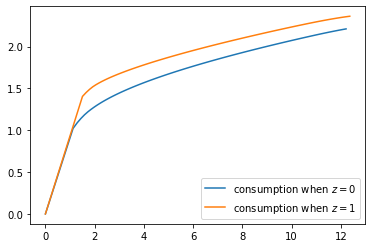

In [10]:
fig, ax = plt.subplots()
for z in range(len(ifp.P)):
    ax.plot(a_star[:, z], σ_star[:, z], label=f"consumption when $z={z}$")

plt.legend()
plt.show()

Notice that we consume all assets in the lower range of the asset space.

This is because we anticipate income $ Y_{t+1} $ tomorrow, which makes the need to save less urgent.

Can you explain why consuming all assets ends earlier (for lower values of
assets) when $ z=0 $?

### Law of Motion

Let’s try to get some idea of what will happen to assets over the long run
under this consumption policy.

As with our [earlier lecture](https://python.quantecon.org/ifp.html) on the income fluctuation problem, we
begin by producing a 45 degree diagram showing the law of motion for assets

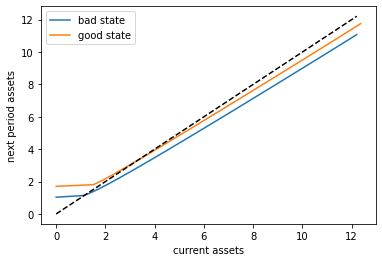

In [11]:
# Good and bad state mean labor income
Y_mean = [np.mean(ifp.Y(z, ifp.η_draws)) for z in (0, 1)]
# Mean returns
R_mean = np.mean(ifp.R(z, ifp.ζ_draws))

a = a_star
fig, ax = plt.subplots()
for z, lb in zip((0, 1), ('bad state', 'good state')):
    ax.plot(a[:, z], R_mean * (a[:, z] - σ_star[:, z]) + Y_mean[z] , label=lb)

ax.plot(a[:, 0], a[:, 0], 'k--')
ax.set(xlabel='current assets', ylabel='next period assets')

ax.legend()
plt.show()

The unbroken lines represent, for each $ z $, an average update function
for assets, given by

$$
a \mapsto \bar R (a - \sigma^*(a, z)) + \bar Y(z)
$$

Here

- $ \bar R = \mathbb E R_t $, which is mean returns and  
- $ \bar Y(z) = \mathbb E_z Y(z, \eta_t) $, which is mean labor income in state $ z $.  


The dashed line is the 45 degree line.

We can see from the figure that the dynamics will be stable — assets do not
diverge even in the highest state.

## Exercises

### Exercise 1

Let’s repeat our [earlier exercise](https://python.quantecon.org/ifp.html#ifp-lrex) on the long-run
cross sectional distribution of assets.

In that exercise, we used a relatively simple income fluctuation model.

In the solution, we found the shape of the asset distribution to be unrealistic.

In particular, we failed to match the long right tail of the wealth distribution.

Your task is to try again, repeating the exercise, but now with our more sophisticated model.

Use the default parameters.

## Solutions

### Exercise 1

First we write a function to compute a long asset series.

Because we want to JIT-compile the function, we code the solution in a way
that breaks some rules on good programming style.

For example, we will pass in the solutions `a_star, σ_star` along with
`ifp`, even though it would be more natural to just pass in `ifp` and then
solve inside the function.

The reason we do this is because (**Issue: that**) `solve_model_time_iter` is not
JIT-compiled.

In [12]:
@njit
def compute_asset_series(ifp, a_star, σ_star, z_seq, T=500_000):
    """
    Simulates a time series of length T for assets, given optimal
    savings behavior.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t}

    """

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_star[:, z], σ_star[:, z], a)

    # Simulate the asset path
    a = np.zeros(T+1)
    for t in range(T):
        z = z_seq[t]
        ζ, η = np.random.randn(), np.random.randn()
        R = ifp.R(z, ζ)
        Y = ifp.Y(z, η)
        a[t+1] = R * (a[t] - σ(a[t], z)) + Y
    return a

Now we call the function, generate the series and then histogram it, using the
solutions computed above.

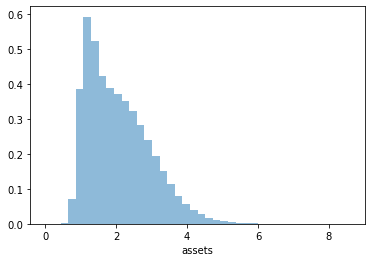

In [13]:
T = 1_000_000
mc = MarkovChain(ifp.P)
z_seq = mc.simulate(T, random_state=1234)

a = compute_asset_series(ifp, a_star, σ_star, z_seq, T=T)

fig, ax = plt.subplots()
ax.hist(a, bins=40, alpha=0.5, density=True)
ax.set(xlabel='assets')
plt.show()

Now we have managed to successfully replicate the long right tail of the
wealth distribution.

Here’s another view of this using a horizontal violin plot.

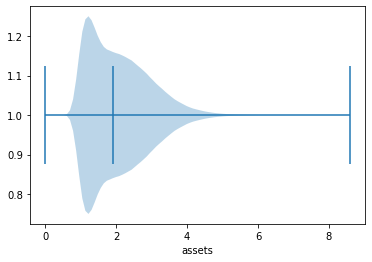

In [14]:
fig, ax = plt.subplots()
ax.violinplot(a, vert=False, showmedians=True)
ax.set(xlabel='assets')
plt.show()